<a href="https://colab.research.google.com/github/daniela150803/LINEAR-REGRESSION/blob/main/Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerias

In [1]:
!pip install keras-tuner
# Carga de librerías
import torch
import numpy as np
import random
import tensorflow as tf
import kerastuner as kt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD,Adam,RMSprop



<ipython-input-1-584e81c4863c>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical

Dataset

In [3]:

from torchvision import datasets, transforms

# Descargar el dataset EMNIST desde torchvision (Este es un dataset de letras, no de dígitos)
emnist_train = datasets.EMNIST(root="./data", train=True, download=True, split='letters', transform=transforms.ToTensor())
emnist_test = datasets.EMNIST(root="./data", train=False, download=True, split='letters', transform=transforms.ToTensor())

# Dimensiones

# Ver las dimensiones de los datos de entrenamiento
print("Dimensiones de las imágenes de entrenamiento:", emnist_train.data.shape)
print("Dimensiones de las etiquetas de entrenamiento:", emnist_train.targets.shape)

# Ver las dimensiones de los datos de prueba
print("Dimensiones de las imágenes de prueba:", emnist_test.data.shape)
print("Dimensiones de las etiquetas de prueba:", emnist_test.targets.shape)

Dimensiones de las imágenes de entrenamiento: torch.Size([124800, 28, 28])
Dimensiones de las etiquetas de entrenamiento: torch.Size([124800])
Dimensiones de las imágenes de prueba: torch.Size([20800, 28, 28])
Dimensiones de las etiquetas de prueba: torch.Size([20800])


Reshape a un tensor de 4 dimensiones: batch size, width, height, color channels

In [4]:
# Establecer una semilla para reproducibilidad
np.random.seed(42)

# Convertir las imágenes a un tensor de 4 dimensiones
x_train = emnist_train.data.numpy()
x_test = emnist_test.data.numpy()

# Obtener las etiquetas
y_train = emnist_train.targets.numpy()
y_test = emnist_test.targets.numpy()

# Añadir una dimensión para los canales de color (1 para escala de grises)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Aleatorizar datos de entrenamiento
train_indices = np.random.permutation(len(x_train))
x_train = x_train[train_indices]
y_train = y_train[train_indices]

# Aleatorizar datos de prueba
test_indices = np.random.permutation(len(x_test))
x_test = x_test[test_indices]
y_test = y_test[test_indices]

# Normalizar las imágenes (escalar los valores de píxeles al rango [0, 1])
x_train = x_train / 255.0
x_test = x_test / 255.0

# Verificar las dimensiones y la aleatorización
print("Dimensiones de las imágenes de entrenamiento:", x_train.shape)
print("Dimensiones de las imágenes de prueba:", x_test.shape)
print("Primeras 5 etiquetas de entrenamiento después de la aleatorización:", y_train[:5])
print("Primeras 5 etiquetas de prueba después de la aleatorización:", y_test[:5])

Dimensiones de las imágenes de entrenamiento: (124800, 28, 28, 1)
Dimensiones de las imágenes de prueba: (20800, 28, 28, 1)
Primeras 5 etiquetas de entrenamiento después de la aleatorización: [13 10 19 24 14]
Primeras 5 etiquetas de prueba después de la aleatorización: [25  8  8 18 12]


In [5]:
#etiqueta de entrenamiento
y_train

array([13, 10, 19, ..., 22, 11, 17])

In [6]:
# Representación one-hot (categórica)
y_train = to_categorical(y_train - 1)  # Restar 1 ya que EMNIST tiene etiquetas desde 1 a 26 (de la A a la Z)
y_test = to_categorical(y_test - 1)    # Restar 1

Modelo 1

In [ ]:
# Hiperparámetros
batch_size = 64
lr = 0.001
num_epochs = 15
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = "categorical_crossentropy"
metrics = ["accuracy"]

model = Sequential([
    Flatten(input_shape=(28, 28, 1)),  # Aplanar la imagen a un vector
    Dense(128, activation='relu'),     # Capa oculta con 128 neuronas y activación ReLU
    Dense(64, activation='relu'),      # Otra capa oculta con 64 neuronas
    Dense(26, activation='softmax')    # Capa de salida con 10 neuronas (una por clase) y activación softmax
])
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


Herramienta Tuner

In [ ]:

def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units1, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))

    # Tune the number of units in the second Dense layer
    # Choose an optimal value between 32-512
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units2, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))

    model.add(Dense(26, activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Tune the optimizer
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if hp_optimizer == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)
    else:
        optimizer = SGD(learning_rate=hp_learning_rate, momentum=0.9)


    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)


tuner.search(x_train, y_train, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')}, the optimal number of units in the second densely-connected
layer is {best_hps.get('units2')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, and the optimal optimizer is {best_hps.get('optimizer')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Modelo 2

In [8]:

# Hiperparámetros modificados
batch_size = 128  # Aumentamos el tamaño del batch para mayor estabilidad
lr = 0.00005      # Reducimos la tasa de aprendizaje para un ajuste más fino
num_epochs = 30   # Aumentamos el número de épocas
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = "categorical_crossentropy"
metrics = ["accuracy"]
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),  # Aplanar la imagen a un vector
    Dense(512, activation='relu'),     # Capa oculta con 512 neuronas (aumentamos)
    Dense(128, activation='relu'),     # Otra capa oculta con 128 neuronas (aumentamos)
    Dense(26, activation='softmax')    # Capa de salida con 26 neuronas (una por clase) y activación softmax
])
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Modelo 3

In [9]:
# Hiperparámetros ajustados
batch_size = 128
lr = 0.0001
num_epochs = 50
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = "categorical_crossentropy"
metrics = ["accuracy"]

# Definir el modelo con regularización y dropout
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),  # Aplanar la imagen a un vector
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Capa oculta con 256 neuronas y regularización L2
    Dropout(0.3),  # Dropout del 30%
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Otra capa oculta con 128 neuronas y regularización L2
    Dropout(0.3),  # Dropout del 30%
    Dense(26, activation='softmax')  # Capa de salida con 26 neuronas (una por clase) y activación softmax
])

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Modelo 4

In [7]:
# Hiperparámetros ajustados
batch_size = 64
lr = 0.01  # Tasa de aprendizaje más alta para SGD
momentum = 0.9  # Momentum para acelerar el entrenamiento
num_epochs = 50
optimizer =  SGD(learning_rate=lr, momentum=momentum)   # Usar SGD con momentum
loss = "categorical_crossentropy"
metrics = ["accuracy"]

# Definir el modelo con regularización y dropout
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(26, activation='softmax')
])
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo 5

In [9]:
# Hiperparámetros ajustados
batch_size = 64
lr = 0.001  # Tasa de aprendizaje más baja
momentum = 0.9
num_epochs = 100
optimizer = Adam(learning_rate=lr)  # Usar Adam en lugar de SGD
loss = "categorical_crossentropy"
metrics = ["accuracy"]

# Definir el modelo con regularización y dropout
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    Dense(26, activation='softmax')
])

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo 6

In [ ]:
# Hiperparámetros ajustados
batch_size = 80
lr = 0.001  # Tasa de aprendizaje reducida para RMSprop
num_epochs = 30
optimizer = RMSprop(learning_rate=lr)  # Usar RMSprop
loss = "categorical_crossentropy"
metrics = ["accuracy"]

# Definir el modelo con regularización y dropout mejorado
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(300, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.1),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.1),
    Dense(26, activation='softmax')
])
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Modelo 7

In [53]:
# Hiperparámetros ajustados
batch_size = 195
lr = 0.01  # Tasa de aprendizaje más alta para SGD
momentum = 0.95  # Momentum para acelerar el entrenamiento
num_epochs = 49
optimizer =  SGD(learning_rate=lr, momentum=momentum)   # Usar SGD con momentum
loss = "categorical_crossentropy"
metrics = ["accuracy"]

# Definir el modelo con regularización y dropout
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(320, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    Dense( 384, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    Dense(26, activation='softmax')
])
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Entrenamiento

In [54]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)

Epoch 1/49
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.4520 - loss: 1.9707 - val_accuracy: 0.8010 - val_loss: 0.7559
Epoch 2/49
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7717 - loss: 0.8423 - val_accuracy: 0.8491 - val_loss: 0.5833
Epoch 3/49
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8187 - loss: 0.6877 - val_accuracy: 0.8657 - val_loss: 0.5137
Epoch 4/49
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8406 - loss: 0.6034 - val_accuracy: 0.8792 - val_loss: 0.4717
Epoch 5/49
512/512 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8545 - loss: 0.5546 - val_accuracy: 0.8870 - val_loss: 0.4434
Epoch 6/49
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8623 - loss: 0.5256 - val_accuracy: 0.8945 - val_loss: 0.4203
Epoch 7/49
512/512 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8721 - loss: 0.4980 - val_accuracy: 0.8965 - val_loss: 0.4114
Epoch 8/49
512/512 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8742 - loss: 0.4826 - val

Evolucion del algoritmo

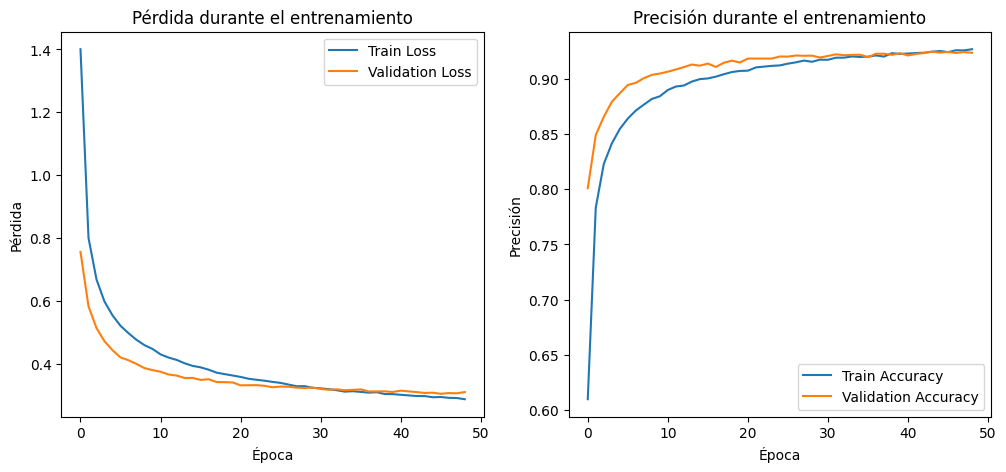

In [55]:
# Graficar la evolución de la pérdida y la precisión durante el entrenamiento
plt.figure(figsize=(12, 5))

# Gráfica de la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()


Prueba del modelo

In [51]:
# Evaluar el modelo con los datos de prueba
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")

# Obtener la precisión de entrenamiento y validación
train_accuracy = history.history['accuracy'][-1]  # Último valor de la precisión de entrenamiento
val_accuracy = history.history['val_accuracy'][-1]  # Último valor de la precisión de validación

print(f"Precisión de entrenamiento: {train_accuracy:.4f}")
print(f"Precisión de validación: {val_accuracy:.4f}")

# Predicciones en el conjunto de prueba
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

650/650 - 2s - 4ms/step - accuracy: 0.9235 - loss: 0.3173
Precisión en el conjunto de prueba: 0.9235
Pérdida en el conjunto de prueba: 0.3173
Precisión de entrenamiento: 0.9281
Precisión de validación: 0.9238
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


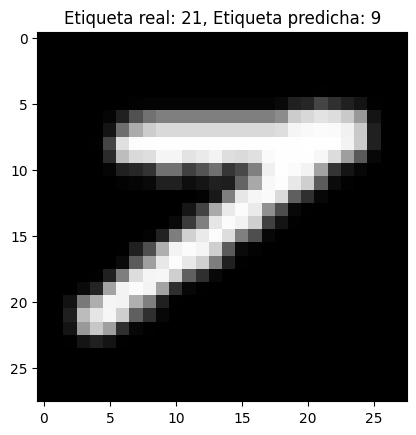

Probabilidades de predicción: [[2.2377948e-04 1.5599540e-04 6.3697614e-02 8.3710771e-04 4.2527466e-04
  7.0546276e-04 8.0067507e-04 1.5919787e-03 7.9114228e-02 4.8298126e-01
  4.3794429e-05 3.0759370e-01 6.7988287e-05 3.7715462e-04 2.3316455e-03
  1.1207182e-04 7.6272561e-05 1.9366824e-04 8.2101012e-03 1.7259762e-02
  3.3242824e-03 6.1204373e-03 5.9550564e-04 1.1863136e-04 2.0864809e-02
  2.1768746e-03]]
Etiqueta predicha: 9, Etiqueta real: 21


In [52]:
# Seleccionar una muestra aleatoria del dataset de test
sample_index = np.random.randint(0, len(x_test))  # Selecciona un índice aleatorio
sample_image = x_test[sample_index]
sample_label = np.argmax(y_test[sample_index])  # Obtén la etiqueta real

# Preprocesar la muestra (si es necesario)
sample_image = sample_image / 255.0  # Normalizar la imagen
sample_image = np.expand_dims(sample_image, axis=0)  # Cambiar la forma para que coincida con la entrada del modelo

# Realizar la predicción
predicted_probabilities = model.predict(sample_image)
predicted_label = np.argmax(predicted_probabilities, axis=1)

# Mostrar la imagen y la predicción
plt.imshow(sample_image[0, :, :, 0], cmap='gray')
plt.title(f'Etiqueta real: {sample_label}, Etiqueta predicha: {predicted_label[0]}')
plt.show()

# Mostrar las probabilidades de predicción
print(f"Probabilidades de predicción: {predicted_probabilities}")
print(f"Etiqueta predicha: {predicted_label[0]}, Etiqueta real: {sample_label}")